# COMP47590: Advanced Machine Learning
# Assignment 1: The Super Learner
# Name: Bhavesh Kumar
# Student No. 16203173

## Import required packages

In [2]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from IPython.display import display, HTML, Image
from sklearn import metrics, model_selection
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import Imputer

%matplotlib inline
#%qtconsole

### Kohavi-Wolpert Variance Method (KW) 

In [3]:
def calculate_kw_variance(pred_label, y_true):
    ''' Kihavi-Wolpert variance is used to measure the variability of predicted class label for the complete dataset and
    also it is one of the recommended way out of six non-pairwise measure to calculate diversity of the classifier in an 
    ensemble of classifiers [1]. 
    
    Parameters
    ----------
    pred_label: predict values array of shape = [n_samples]
    y_true: true values array of shape = [n_samples]
    
    Returs
    ------
    kw_score: return the consolidated score including all the classifiers for every samples.
    '''
    y_true_count = [0 for i in range(len(y_true))] 
    kw_score = 0
    for i, value in enumerate(y_true):
        for pred in pred_label:
            if value == pred[i]:
                y_true_count[i] += 1
        kw_score += y_true_count[i]*(len(pred_label)-y_true_count[i])
    return kw_score/float(len(y_true)*pow(len(pred_label),2))

## Define Super Learner Classifier

The *Super Learner* is a heterogeneous stacked ensemble classifier. This is a classification model that uses a set of base classifiers of different types, the outputs of which are then combined in another classifier at the stacked layer. The Super Learner was described in [(van der Laan et al, 2007)](https://pdfs.semanticscholar.org/19e9/c732082706f39d2ba12845851309714db135.pdf) but the stacked ensemble idea has been around for a long time. 

Figure 1 shows a flow diagram of the Super Learner process (this is from (van der Laan et al, 2007) and the process is also described in the COMP47590 lecture "[COMP47590 2017-2018 L04 Supervised Learning Ensembles 3](https://www.dropbox.com/s/1ksx94nxtuyn4l8/COMP47590%202017-2018%20L04%20Supervised%20Learning%20Ensembles%203.pdf?raw=1)"). The base classifiers are trained and their outputs are combined along with the training dataset labels into a training set for the stack layer classifier. To avoid overfitting the generation of the stacked layer training set uses a k-fold cross validation process (described as V-fold in Figure 1). To further add variety to the base estimators a bootstrapping selection (as is used in the bagging ensemble approach).
 
![Super Learner Process Flow](SuperLearnerProcessFlow.png "Logo Title Text 1")
Figure 1: A flow diagram for the Super Learner


### Define the SuperLearnerClassifier Class

In [4]:
# Create a new classifier which is based on the sckit-learn BaseEstimator and ClassifierMixin classes
class SuperLearnerClassifier(BaseEstimator, ClassifierMixin):
    
    """An ensemble classifier that uses heterogeneous models at the base layer and a aggregatnio model at the aggregation layer.
    A k-fold cross validation is used to gnerate training data for the stack layer model.

    Parameters
    ----------
    BaseEstimator: It is the base class for all sklearn estimators.
    ClassifierMixin: This is one the the default class which every sklearn estimators must implement and expose score
    method to get mean accuracy
        
    Attributes
    ----------

    Notes
    -----
    
    See also
    --------
    
    ----------
    .. [1]  van der Laan, M., Polley, E. & Hubbard, A. (2007). 
            Super Learner. Statistical Applications in Genetics 
            and Molecular Biology, 6(1) 
            doi:10.2202/1544-6115.1309
    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.model_selection import cross_val_score
    >>> clf = SuperLearnerClassifier()
    >>> iris = load_iris()
    >>> cross_val_score(clf, iris.data, iris.target, cv=10)

    """
    # Constructor for the classifier object
    def __init__(self, estimators = None, meta_learner = None, n_splits=2, 
                 proba_based_stacking=False, input_at_stack_layer=False):
        """Setup a SuperLearner classifier .
        
        Parameters
        ----------
        estimators: dictionary like structure to have base estimators key-value pair as name and object of classfier
        meta_learner: a classifier to train on the output of stacked model
        n_splits: number to split dataset in kfold and also specifies value for cross-validation cv=n_splits
        proba_based_stacking: boolean variable with true and false, represent whether to use probablity based or label based 
                            output to train meta_learner
        input_at_stack_layer: boolean variable to know whether to append input sample X at stacked layer to use only 
                            stacked layer output data
        
        Returns
        -------
        sets required parameters to the self object of SuperLearner classifier

        """   
        if estimators is None:
            dt = DecisionTreeClassifier()
            rf = RandomForestClassifier()
            lr = LogisticRegression()
            svc = SVC(probability=True)
            gb = GradientBoostingClassifier()
            g_nb = GaussianNB()
            self.estimators = {"DecisionTree":dt, "RandomForest":rf, "LogisticRegression":lr, "SVC":svc, 
                               "GBoost":gb, "GaussionNB": g_nb}
        else:
            self.estimators = estimators
        
        if meta_learner is None:
            self.meta_learner = DecisionTreeClassifier()
        else:
            self.meta_learner = meta_learner
            
        self.n_splits = n_splits
        self.proba_based_stacking = proba_based_stacking
        self.base_learner_accuracy_comparisons = dict()
        self.input_at_stack_layer = input_at_stack_layer
        self.base_models_data = dict()
        self.base_models_cross_val_score = dict()
        

    # The fit function to train a classifier
    def fit(self, X, y):
        """Build a SuperLearner classifier from the training set (X, y).
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            The training input samples. 
        y : array-like, shape = [n_samples] 
            The target values (class labels) as integers or strings.
        Returns
        -------
        self : object
        """     
        # generate stacked layer training set
        kf = KFold(n_splits=self.n_splits)
        stacked_feature = []
        for name, model in self.estimators.items():
            model_preds = []
            base_model_true = []
            base_model_pred = []
            for train_index, valid_index in kf.split(X):
                X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
                y_train, y_valid = y[train_index], y[valid_index]
                model.fit(X_train,y_train)
                if self.proba_based_stacking:
                    y_pred = model.predict_proba(X_valid)
                    base_model_pred.append(model.predict(X_valid)) # store pred label of base model
                else:
                    y_pred = model.predict(X_valid)
                    base_model_pred.append(y_pred) # store pred label of base model
                    y_pred = y_pred.reshape((-1,1))
                model_preds.append(y_pred)   
                base_model_true.append(y_valid) # store true label of base model
            model_preds = np.concatenate(model_preds)
            stacked_feature.append(model_preds)
            
            # store true and pred data to calculate performance
            self.base_models_data[name] = {"true_label" : np.concatenate(base_model_true),
                                          "pred_label" : np.concatenate(base_model_pred)}
            # calculate cross validation score of base models to check performance
            self.base_models_cross_val_score[name] = model_selection.cross_val_score(model, X, y, cv=self.n_splits, scoring='accuracy')
            
        stacked_feature = np.concatenate(stacked_feature, axis=1)
        if self.input_at_stack_layer is True:
            stacked_feature = np.concatenate((stacked_feature, X), axis=1)
        self.meta_learner.fit(stacked_feature, y)
        # Return the classifier
        return self

    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        """Predict class labels of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, ].
            The predicted class labels of the input samples. 
        """
        stacked_feature = []
        for name, model in self.estimators.items():
            if self.proba_based_stacking:
                y_pred = model.predict_proba(X)
            else:
                y_pred = model.predict(X)
                y_pred = y_pred.reshape((-1,1))
            stacked_feature.append(y_pred)
        stacked_feature = np.concatenate(stacked_feature, axis=1)
        if self.input_at_stack_layer is True:
            stacked_feature = np.concatenate((stacked_feature, X), axis=1)
        return self.meta_learner.predict(stacked_feature)
    
    # The predict function to make a set of predictions for a set of query instances
    def predict_proba(self, X):
        """Predict class probabilities of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, n_labels].
            The predicted class label probabilities of the input samples. 
        """
        stacked_feature = []
        for name, model in self.estimators.items():
            if self.proba_based_stacking:
                y_pred = model.predict_proba(X)
            else:
                y_pred = model.predict(X)
                y_pred = y_pred.reshape((-1,1))
            stacked_feature.append(y_pred)
        stacked_feature = np.concatenate(stacked_feature, axis=1)
        return self.meta_learner.predict_proba(stacked_feature) 
    
    # The performance report function to generate performance report of base learner
    def print_base_models_performance_report(self):
        base_models_accuracy, base_models_name = [], []
        print("Accuracy of base classifiers")
        for name, accuracy in self.base_models_cross_val_score.items():
            base_models_name.append(name)
            base_models_accuracy.append(accuracy)
            print("%s: %0.2f (+/- %0.2f)" % (name, accuracy.mean(), accuracy.std() * 2))
        
        # plotting box and whisker to compare base models performance
        fig = plt.figure(figsize = (12,7))
        fig.suptitle('Base Models Accuracy Comparison')
        ax = fig.add_subplot(111)
        plt.boxplot(base_models_accuracy)
        ax.set_xticklabels(base_models_name)
        ax.set_xlabel('Methods')
        ax.set_ylabel('Accuracy')
        plt.show()
    
        pred_list, true_list = [], []
        for name, data in self.base_models_data.items():
            pred_list.append(data['pred_label'])
            if len(true_list) is 0:
                true_list = data['true_label']

        # pairwise correlation
        data = { name:data['pred_label'] for name, data in self.base_models_data.items()}
        df = pd.DataFrame(data=data)
        print("Correlation coefficient of classifiers")
        print(df.corr().round(2)) # using pearson correlation coefficient
        
        # Calculate Kohavi-Wolpert score
        kw_score = calculate_kw_variance(pred_list, true_list)
        print("Kohavi-Wolpert variance score: %0.2f" % (kw_score))

### Test the SuperLearnerClassifier

Perform a simple test using the SuperLearnClassifier on the Iris dataset

In [4]:
from sklearn.datasets import load_iris
clf = SuperLearnerClassifier(proba_based_stacking=True)
iris = load_iris()
clf.fit(pd.DataFrame(iris.data), iris.target)
scores = cross_val_score(clf, pd.DataFrame(iris.data), iris.target, cv=5)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[0.96666667 0.96666667 0.9        0.93333333 0.96666667]
Accuracy: 0.95 (+/- 0.05)


## Load & Partition Data

### Setup - IMPORTANT

Take only a sample of the dataset for fast testing

In [5]:
data_sampling_rate = 0.01

Setup the number of folds for all grid searches (should be 5 - 10)

In [6]:
cv_folds = 5

### Load Dataset

Load the dataset and explore it.

In [7]:
dataset = pd.read_csv('fashion-mnist_train.csv')
dataset = dataset.sample(frac=data_sampling_rate) #take a sample from the dataset so everyhting runs smoothly
num_classes = 10
classes = {0: "T-shirt/top", 1:"Trouser", 2: "Pullover", 3:"Dress", 4:"Coat", 5:"Sandal", 6:"Shirt", 7:"Sneaker", 8:"Bag", 9:"Ankle boot"}
display(dataset.head())

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
52709,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
47845,4,0,0,0,0,0,0,0,0,1,...,3,4,0,0,132,162,42,0,0,0
2609,1,0,0,0,0,0,0,0,0,0,...,92,94,0,0,0,0,0,0,0,0
34293,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59820,3,0,0,0,0,0,0,0,0,0,...,99,82,5,0,0,0,0,0,0,0


### Pre-process & Partition Data

Perform data pre-processing and manipulation as required

In [8]:
# take input and label data from dataset
X = dataset[dataset.columns[1:]]
Y = np.array(dataset["label"])

# Normalize X
X = X/255

In [9]:
# check if dataset contains null values
dataset.isnull().any().any()

False

In [10]:
# split data into train, valid and test
X_train_plus_valid, X_test, y_train_plus_valid, y_test = train_test_split(X, Y, random_state=0, test_size = 0.3)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_plus_valid, y_train_plus_valid,random_state=0, test_size = 0.3)

## Train and Evaluate a Simple Model

### Basic Decision Tree

In [11]:
decision_tree = DecisionTreeClassifier(criterion="entropy")
decision_tree.fit(X_train_plus_valid,y_train_plus_valid)
y_pred = decision_tree.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy: " +  str(accuracy))

Accuracy: 0.7055555555555556


Train a Super Learner Classifier using the prepared dataset

In [12]:
super_learner = SuperLearnerClassifier(n_splits=cv_folds, proba_based_stacking=True)
super_learner.fit(X_train_plus_valid,y_train_plus_valid)

SuperLearnerClassifier(estimators={'DecisionTree': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_frac...e, subsample=1.0, verbose=0,
              warm_start=False), 'GaussionNB': GaussianNB(priors=None)},
            input_at_stack_layer=False,
            meta_learner=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
            n_splits=5, proba_based_stacking=True)

Evaluate the trained classifier

Accuracy of SuperLearner: 0.7166666666666667

Classification report
             precision    recall  f1-score   support

          0       0.54      0.54      0.54        13
          1       1.00      0.73      0.84        22
          2       0.55      0.65      0.59        17
          3       0.58      0.83      0.68        18
          4       0.65      0.71      0.68        21
          5       0.81      0.93      0.87        14
          6       0.31      0.21      0.25        19
          7       0.82      0.82      0.82        17
          8       0.94      0.84      0.89        19
          9       0.95      0.90      0.92        20

avg / total       0.72      0.72      0.71       180



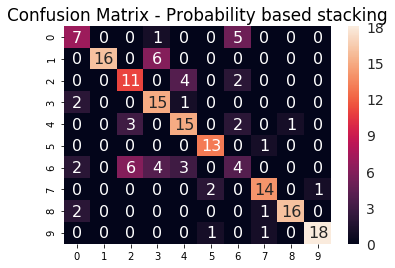

In [13]:
y_pred = super_learner.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy of SuperLearner: " +  str(accuracy))
print("\nClassification report")
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
cm_train = metrics.confusion_matrix(y_test, y_pred)

ax = plt.axes()
plt.figure(figsize = (7,5))
sn.set(font_scale=1.4)
sn.heatmap(cm_train, annot=True,annot_kws={"size": 16}, ax=ax, fmt='g')# font size
ax.set_title('Confusion Matrix - Probability based stacking')
plt.show()

## Cross Validation Experiment (Task 2)

Perfrom a 10-fold cross validation experiment to evaluate the performance of the SuperLearnerClassifier

In [14]:
# Add code here
scores = cross_val_score(super_learner, X, Y, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.69 (+/- 0.14)


## Comparing the Performance of Different Stack Layer Approaches (Task 5)

Compare the performance of the ensemble when a label based stack layer training set and a probability based stack layer training set is used.

Accuracy: 0.6944444444444444

Classification report
             precision    recall  f1-score   support

          0       0.50      0.54      0.52        13
          1       1.00      0.77      0.87        22
          2       0.63      0.71      0.67        17
          3       0.65      0.83      0.73        18
          4       0.69      0.52      0.59        21
          5       0.63      0.86      0.73        14
          6       0.47      0.37      0.41        19
          7       0.74      0.82      0.78        17
          8       0.65      0.79      0.71        19
          9       1.00      0.75      0.86        20

avg / total       0.71      0.69      0.69       180



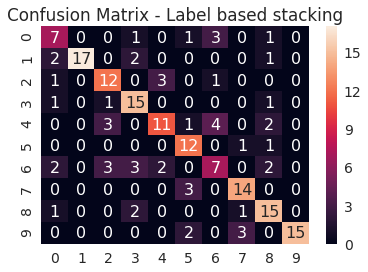

In [15]:
# Add code here
super_learner1 = SuperLearnerClassifier(n_splits=cv_folds, proba_based_stacking=False)
super_learner1.fit(X_train_plus_valid,y_train_plus_valid)

y_pred = super_learner1.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy: " +  str(accuracy))
print("\nClassification report")
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
cm_train = metrics.confusion_matrix(y_test, y_pred)

ax = plt.axes()
plt.figure(figsize = (7,5))
sn.set(font_scale=1.4)
sn.heatmap(cm_train, annot=True,annot_kws={"size": 16}, ax=ax, fmt='g')# font size
ax.set_title('Confusion Matrix - Label based stacking')
plt.show()

## Grid Search Through SuperLearnerClassifier Architectures & Parameters (Task 7)

Perfrom a grid search experiment to detemrine the optimal architecture and hyper-parameter values for the SuperLearnClasssifier for the MNIST Fashion classification problem.

In [17]:
# function to return base learner
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
lr = LogisticRegression()
svc = SVC(probability=True)
gb = GradientBoostingClassifier()
g_nb = GaussianNB()
estimators = {"DecisionTree":dt, "RandomForest":rf, "LogisticRegression":lr, "SVC":svc, "GBoost":gb, "GaussionNB": g_nb}

# Set up the parameter grid for Decision Tree
param_grid ={'estimators': [{"DecisionTree":dt, "RandomForest":rf, "LogisticRegression":lr}, 
                            {"SVC":svc, "GBoost":gb, "GaussionNB": g_nb},
                            {"RandomForest":rf, "LogisticRegression":lr, "SVC":svc}],
             'meta_learner':[DecisionTreeClassifier(), LogisticRegression()],
             'n_splits': [cv_folds], 
             'proba_based_stacking': [True, False]}

# Perform the search
tuned_super_learner = GridSearchCV(SuperLearnerClassifier(), 
                                   param_grid, cv=cv_folds, verbose = 1, 
                                   return_train_score=True,
                                   scoring='accuracy')
tuned_super_learner.fit(X_train_plus_valid, y_train_plus_valid)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 28.8min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=SuperLearnerClassifier(estimators={'DecisionTree': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_spl...random_state=None,
            splitter='best'),
            n_splits=2, proba_based_stacking=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'estimators': [{'DecisionTree': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
           ...01,
          verbose=0, warm_start=False)], 'n_splits': [5], 'proba_based_stacking': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accurac

Evaluate the performance of the model selected by the grid search on a hold-out dataset

Best parameters set found on training set:


{'estimators': {'LogisticRegression': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False),
  'RandomForest': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=None, max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
              oob_score=False, random_state=None, verbose=0,
              warm_start=False),
  'SVC': SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Accuracy: 0.7944444444444444

Classification report
             precision    recall  f1-score   support

          0       0.67      0.92      0.77        13
          1       0.94      0.77      0.85        22
          2       0.68      0.76      0.72        17
          3       0.68      0.83      0.75        18
          4       0.71      0.71      0.71        21
          5       0.93      1.00      0.97        14
          6       0.58      0.37      0.45        19
          7       0.93      0.82      0.87        17
          8       0.89      0.89      0.89        19
          9       0.90      0.95      0.93        20

avg / total       0.80      0.79      0.79       180



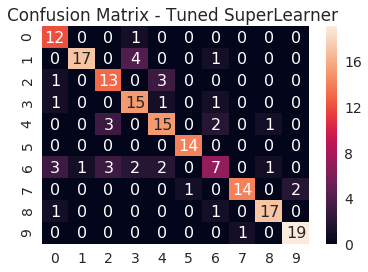

In [18]:
y_pred = tuned_super_learner.predict(X_test)

# Print details
print("Best parameters set found on training set:")
display(tuned_super_learner.best_params_)

# Calculate classification accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy: " +  str(accuracy))
print("\nClassification report")
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
cm_train = metrics.confusion_matrix(y_test, y_pred)

ax = plt.axes()
plt.figure(figsize = (7,5))
sn.set(font_scale=1.4) #for label size
sn.heatmap(cm_train, annot=True,annot_kws={"size": 16}, ax=ax, fmt='g')# font size
ax.set_title('Confusion Matrix - Tuned SuperLearner ')
plt.show()

## Evaluating the Impact of Adding Original Descriptive Features at the Stack Layer (Task 8)

Evaluate the impact of adding original descriptive features at the stack layer.

Accuracy: 0.7888888888888889

Classification report
             precision    recall  f1-score   support

          0       0.71      0.92      0.80        13
          1       1.00      0.77      0.87        22
          2       0.76      0.76      0.76        17
          3       0.70      0.89      0.78        18
          4       0.64      0.67      0.65        21
          5       0.93      0.93      0.93        14
          6       0.57      0.42      0.48        19
          7       0.87      0.76      0.81        17
          8       0.89      0.89      0.89        19
          9       0.86      0.95      0.90        20

avg / total       0.79      0.79      0.79       180



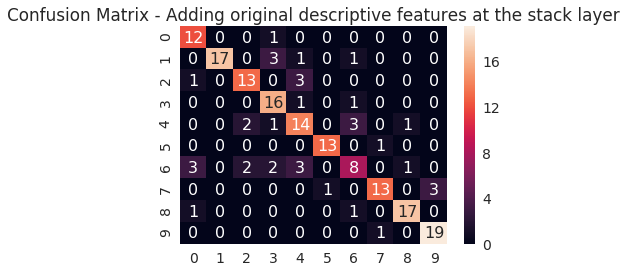

In [19]:
# using best configuration from GridSearchCV result
estimators = {"LogisticRegression":lr, "RandomForest":rf, "SVC":svc}
meta_learner = LogisticRegression()
n_splits = cv_folds

# training SuperLearnerClassifier with best configuration
super_learner2 = SuperLearnerClassifier(estimators = estimators, meta_learner = meta_learner, n_splits=n_splits, proba_based_stacking=True, input_at_stack_layer=True)
super_learner2.fit(X_train_plus_valid,y_train_plus_valid)

y_pred = super_learner2.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy: " +  str(accuracy))
print("\nClassification report")
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
cm_train = metrics.confusion_matrix(y_test, y_pred)

ax = plt.axes()
plt.figure(figsize = (7,5))
sn.set(font_scale=1.4)
sn.heatmap(cm_train, annot=True,annot_kws={"size": 16}, ax=ax, fmt='g')# font size
ax.set_title('Confusion Matrix - Adding original descriptive features at the stack layer')
plt.show()

## Explore the Ensemble Model (Task 9)

Perform an analysis to investigate the strength of the base estimators and the strengths of the correlations between them.

Accuracy of base classifiers
LogisticRegression: 0.79 (+/- 0.06)
RandomForest: 0.71 (+/- 0.08)
SVC: 0.66 (+/- 0.05)


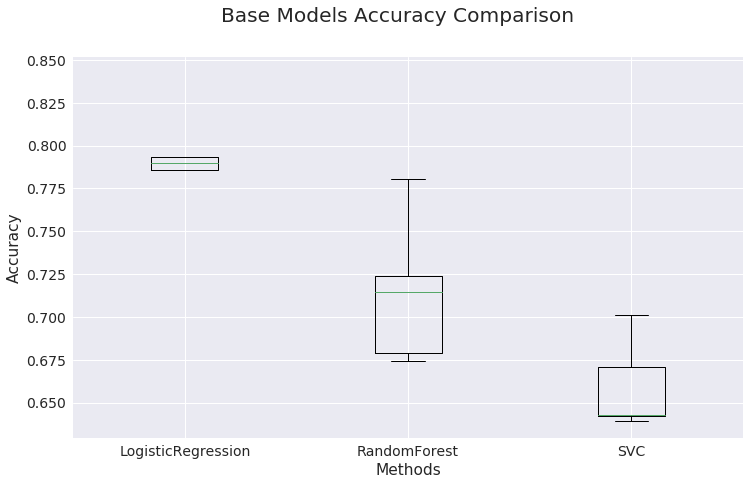

Correlation coefficient of classifiers
                    LogisticRegression  RandomForest   SVC
LogisticRegression                1.00          0.88  0.83
RandomForest                      0.88          1.00  0.85
SVC                               0.83          0.85  1.00
Kohavi-Wolpert variance score: 0.07


In [20]:
'''printing the performance report of print the performance report of SuperLearner classifier which 
uses the best hyperparameter found using GridSearchCV above.
''' 
# print the performance report of Superlearner withh tunned parameter
super_learner2.print_base_models_performance_report()

# plot classification accuracy of base and SuperLearner classifier
classifier_test_accuracy_comparisons = {}
for name, mode_accuracy in super_learner2.base_models_cross_val_score.items():
    classifier_test_accuracy_comparisons[name] = mode_accuracy.mean()
classifier_test_accuracy_comparisons["SuperLearner"] = accuracy

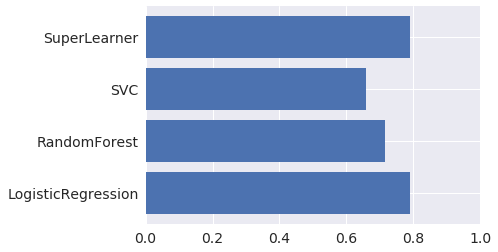

In [21]:
# plot comparison barchart for all the classifiers used in ensemble including SuperLearner
plt.xlim(0, 1.0)
_ = plt.barh(range(len(classifier_test_accuracy_comparisons)), list(classifier_test_accuracy_comparisons.values()), align='center')
_= plt.yticks(range(len(classifier_test_accuracy_comparisons)), list(classifier_test_accuracy_comparisons.keys()))

### Analysis report

In the above experiment, I have used base estimator with default parameters in stacked ensemble and for meta learner classifier as well. Implemented SuperLearner classifier has been tested on Irish dataset and accuracy of this classification is 95%. I have used data sampling factor 5% to get sample of the complete dataset to train and test the SuperLearner classifier and used 5 fold cross validation to evaluate the SuperLearner.

Accuracy of every steps and SuperLearner with various configuration has been metioned below.
1. Decision Tree: 70%
2. SuperLearner with probability based stacking: 71%
3. SuperLearner without probability based stacking: 69%
4. SuperLearner with adding original descriptive features at the Stack Layer: 78%

Analysis:
SuperLearner with adding adding original descriptive feature outperformed (accuracy=78%) every configurations and SuperLearner with probability based stacking seems to be good option after adding descriptive feature methods where it gave 71% accuracy.

I have found best parameters for SuperLearner using GridSeachCV method as follows:
1. Best set of estimators: LogisticRegression, Random Forest, SVC
2. Best meta learner: Logistic Regression (out of Decision Tree and Logistic Regression)
3. Best no. of split: 6, later on while running for the last time because of the time I have changed the configuration in GridSearchCV to make it a little faster.

To evaluate the classifier diversity, I have used two recommended methods where first is Person Correlation cofficient and another is Kihavi-Wolpert variance. It can be clearly seen in the output of SuperLearner performance report in Task 9 section above that as per Pearson Correlation, all the base classifiers are highly correlated to each other and it can also be proved  using Kihavi-Wolpert(kw) variance score, it gives very low score on the predicted data with only 6% where more the kw score better the diversity will be in between the classifiers [1][2].

Possible enhancement in this experiement:
1. Try out various classifier and calculate Kihavi-Wolpert(kw) score to find diverse set of classifier
2. Use these as base classifier in SuperLearn to train and predict.

### References

[1] Masisi, Lesedi & Nelwamondo, Fulufhelo & Marwala, Tshilidzi. (2008). The Effect of Structural Diversity of an Ensemble of   Classifiers on Classification Accuracy. CoRR. abs/0804.4741. <br>
[2] Kuncheva, L.I. & Whitaker, C.J. Machine Learning (2003) 51: 181. https://doi.org/10.1023/A:1022859003006
